# Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import operator
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

# re is used for cleaning the dataset 

import re


import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

# callbacks are important here as sometimes you get the best accuracy earlies and then it 
# goes down so as to stop the training there you need to use them


from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Conv1D,LSTM,GRU,BatchNormalization,Flatten,Dense


for dirname, _, filenames in os.walk('K:\Technical Works\Projects\Sentiment Analysis\Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

K:\Technical Works\Projects\Sentiment Analysis\Dataset\IMDB Dataset.csv


# Data Preprocessing

In [2]:
df = pd.read_csv("K:\Technical Works\Projects\Sentiment Analysis\Dataset\IMDB Dataset.csv")

In [3]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
# Let's find if the data contains any missing value

In [8]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [9]:
# We will find the count of each type of sentiment in the dataset using seaborn library

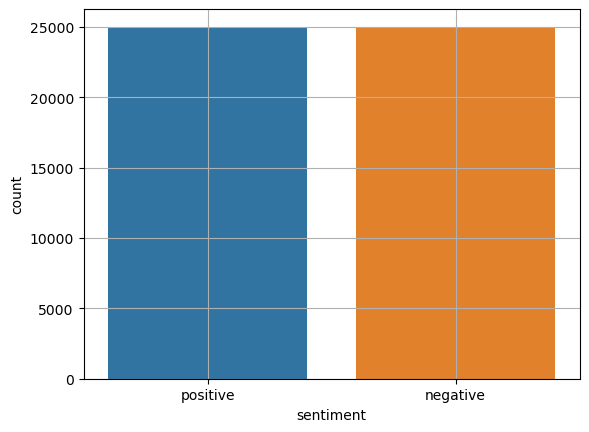

In [10]:
sns.countplot(x=df['sentiment'])
plt.grid()

In [11]:
sentences=df['review']
le=LabelEncoder()
df['sentiment']= le.fit_transform(df['sentiment'])

# Data visualization using word cloud for finding the most used words for each type of sentiment

(-0.5, 799.5, 799.5, -0.5)

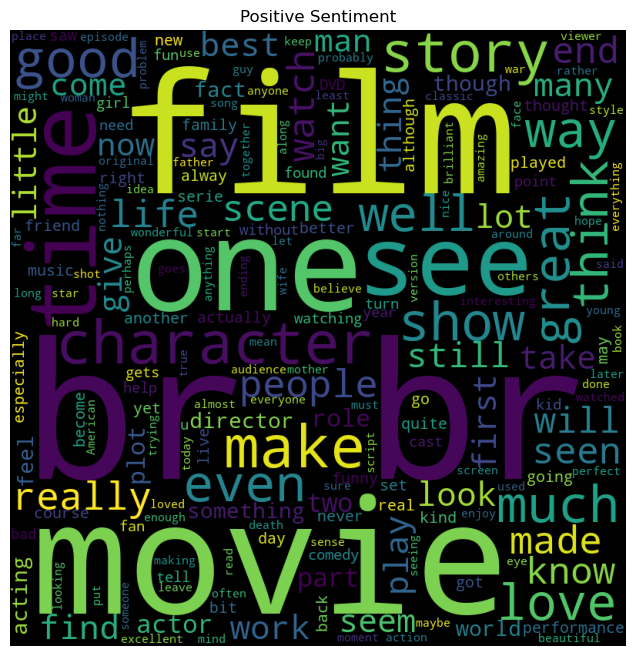

In [12]:
stopwords = set(STOPWORDS) 

pos=' '.join(map(str,sentences[df['sentiment']==1]))
neg=' '.join(map(str,sentences[df['sentiment']==0]))
  
wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(pos) 

plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.title('Positive Sentiment')
plt.axis('off')

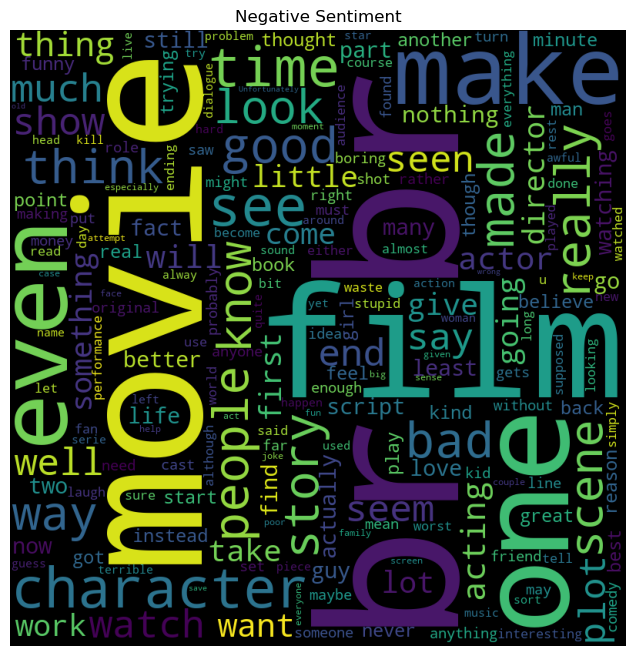

In [13]:
plt.figure(figsize=(8,8))
wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(neg) 

plt.imshow(wordcloud2)
plt.title('Negative Sentiment')
plt.axis('off')

plt.show() 

In [14]:
labels=to_categorical(df['sentiment'],num_classes=2)
X_train,X_test,Y_train,Y_test = train_test_split(df['review'],labels,test_size=0.1,random_state=10)

# Data Cleaning
Note: In this model I will be using glove embeddings.It has a large vocabulary and we can find the words from our data 
    which are not present in the glove( these words are contractions, misspelled words, concated words or emojis which can
                                       decrease our model's performance. We will then use re library to remove these words 
                                       from the dataset.

In [15]:
glove_embeddings= np.load("K:\Technical Works\Projects\Sentiment Analysis\glove.840B.300d.pkl\glove.840B.300d.pkl",
                          allow_pickle=True)

# We will build vocabulary and count of each vocabulary using the below function

In [16]:
def vocab_build(review):
    
    comments = review.apply(lambda s: s.split()).values
    vocab={}
    
    for comment in comments:
        for word in comment:
            try:
                vocab[word]+=1
                
            except KeyError:
                vocab[word]=1
    return vocab

# Embedding Coverage tells how much percentage of the words in our data are covered by the vocabulary.
sorted_oov is the list of words which we need to do text cleaning on.

In [17]:
def embedding_coverage(review,embeddings):
    
    vocab=vocab_build(review)
    
    covered={}
    word_count={}
    oov={}
    covered_num=0
    oov_num=0
    
    for word in vocab:
        try:
            covered[word]=embeddings[word]
            covered_num+=vocab[word]
            word_count[word]=vocab[word]
        except:
            oov[word]=vocab[word]
            oov_num+=oov[word]
    
    vocab_coverage=len(covered)/len(vocab)*100
    text_coverage = covered_num/(covered_num+oov_num)*100
    
    sorted_oov=sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    sorted_word_count=sorted(word_count.items(), key=operator.itemgetter(1))[::-1]
    
    return sorted_word_count,sorted_oov,vocab_coverage,text_coverage

In [18]:
train_covered,train_oov,train_vocab_coverage,train_text_coverage=embedding_coverage(X_train,glove_embeddings)
test_covered,test_oov, test_vocab_coverage, test_text_coverage = embedding_coverage(X_test,glove_embeddings)

print(f"Glove embeddings cover {round(train_vocab_coverage,2)}% of vocabulary and {round(train_text_coverage,2)}% text in training set")
print(f"Glove embeddings cover {round(test_vocab_coverage,2)}% of vocabulary and {round(test_text_coverage,2)}% text in testing set")

Glove embeddings cover 26.74% of vocabulary and 87.62% text in training set
Glove embeddings cover 42.72% of vocabulary and 87.73% text in testing set


# train_oov shows the words which we need to preprocess

In [19]:
train_oov[:10]

[('/><br', 90971),
 ('/>The', 12949),
 ('film,', 7318),
 ('movie,', 7167),
 ('/>I', 6565),
 ("isn't", 5241),
 ('"The', 4379),
 ("he's", 3981),
 ('/>This', 3969),
 ("wasn't", 3788)]

In [20]:
def clean_sentences(line):
    
    line=re.sub('<.*?>','',line) # removing html tags
    
    #removing contractions
    line=re.sub("isn't",'is not',line)
    line=re.sub("he's",'he is',line)
    line=re.sub("wasn't",'was not',line)
    line=re.sub("there's",'there is',line)
    line=re.sub("couldn't",'could not',line)
    line=re.sub("won't",'will not',line)
    line=re.sub("they're",'they are',line)
    line=re.sub("she's",'she is',line)
    line=re.sub("There's",'there is',line)
    line=re.sub("wouldn't",'would not',line)
    line=re.sub("haven't",'have not',line)
    line=re.sub("That's",'That is',line)
    line=re.sub("you've",'you have',line)
    line=re.sub("He's",'He is',line)
    line=re.sub("what's",'what is',line)
    line=re.sub("weren't",'were not',line)
    line=re.sub("we're",'we are',line)
    line=re.sub("hasn't",'has not',line)
    line=re.sub("you'd",'you would',line)
    line=re.sub("shouldn't",'should not',line)
    line=re.sub("let's",'let us',line)
    line=re.sub("they've",'they have',line)
    line=re.sub("You'll",'You will',line)
    line=re.sub("i'm",'i am',line)
    line=re.sub("we've",'we have',line)
    line=re.sub("it's",'it is',line)
    line=re.sub("don't",'do not',line)
    line=re.sub("that´s",'that is',line)
    line=re.sub("I´m",'I am',line)
    line=re.sub("it’s",'it is',line)
    line=re.sub("she´s",'she is',line)
    line=re.sub("he’s'",'he is',line)
    line=re.sub('I’m','I am',line)
    line=re.sub('I’d','I did',line)
    line=re.sub("he’s'",'he is',line)
    line=re.sub('there’s','there is',line)
    
    #special characters and emojis
    line=re.sub('\x91The','The',line)
    line=re.sub('\x97','',line)
    line=re.sub('\x84The','The',line)
    line=re.sub('\uf0b7','',line)
    line=re.sub('¡¨','',line)
    line=re.sub('\x95','',line)
    line=re.sub('\x8ei\x9eek','',line)
    line=re.sub('\xad','',line)
    line=re.sub('\x84bubble','bubble',line)
    
    # remove concated words
    line=re.sub('trivialBoring','trivial Boring',line)
    line=re.sub('Justforkix','Just for kix',line)
    line=re.sub('Nightbeast','Night beast',line)
    line=re.sub('DEATHTRAP','Death Trap',line)
    line=re.sub('CitizenX','Citizen X',line)
    line=re.sub('10Rated','10 Rated',line)
    line=re.sub('_The','_ The',line)
    line=re.sub('1Sound','1 Sound',line)
    line=re.sub('blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah','blah blah',line)
    line=re.sub('ResidentHazard','Resident Hazard',line)
    line=re.sub('iameracing','i am racing',line)
    line=re.sub('BLACKSNAKE','Black Snake',line)
    line=re.sub('DEATHSTALKER','Death Stalker',line)
    line=re.sub('_is_','is',line)
    line=re.sub('10Fans','10 Fans',line)
    line=re.sub('Yellowcoat','Yellow coat',line)
    line=re.sub('Spiderbabe','Spider babe',line)
    line=re.sub('Frightworld','Fright world',line)
    
    #removing punctuations
    
    punctuations = '@#!~?+&*[]-%._-:/£();$=><|{}^' + '''"“´”'`'''
    for p in punctuations:
        line = line.replace(p, f' {p} ')
        
    line=re.sub(',',' , ',line)
        
    # ... and ..
    line = line.replace('...', ' ... ')
    
    if '...' not in line:
        line = line.replace('..', ' ... ')
        
    return line
    

In [21]:
X_train=X_train.apply(lambda s: clean_sentences(s))
X_test=X_test.apply(lambda s: clean_sentences(s))

train_covered,train_oov,train_vocab_coverage,train_text_coverage=embedding_coverage(X_train,glove_embeddings)
print(f"Glove embeddings cover {round(train_vocab_coverage,2)}% of vocabulary and {round(train_text_coverage,2)}% text in training set")

test_covered,test_oov,test_vocab_coverage,test_text_coverage=embedding_coverage(X_test,glove_embeddings)
print(f"Glove embeddings cover {round(test_vocab_coverage,2)}% of vocabulary and {round(test_text_coverage,2)}% text in training set")

Glove embeddings cover 86.92% of vocabulary and 99.82% text in training set
Glove embeddings cover 95.5% of vocabulary and 99.82% text in training set


# using seaborn's barplot let's find out the count of 10 most used words in training and testing set

In [22]:
punctuations = '@#!~?+&*[]-%._-:/£();$=><|{},^' + '''"“´”'`'''
train_word=[]
train_count=[]

i=1
for word,count in train_covered: 
    if word not in punctuations:
        train_word.append(word)
        train_count.append(count)
        i+=1
    if(i==15):
        break

In [23]:
test_word=[]
test_count=[]

i=1
for word,count in test_covered: 
    if word not in punctuations:
        test_word.append(word)
        test_count.append(count)
        i+=1
    if(i==15):
        break

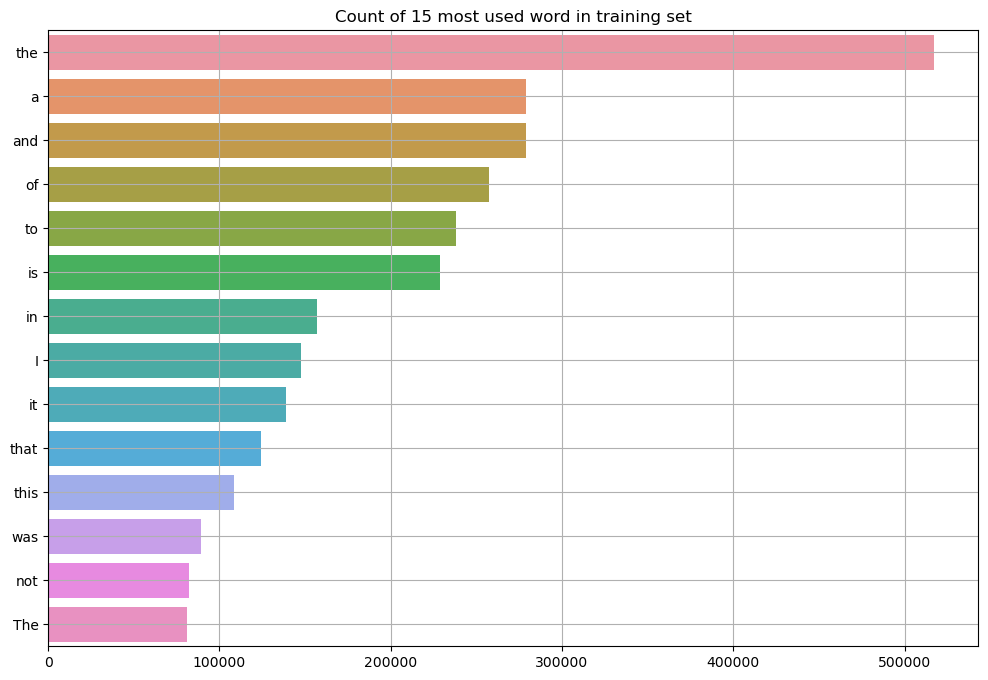

In [24]:
plt.figure(figsize=(12,8))
sns.barplot(x=train_count,y=train_word).set_title('Count of 15 most used word in training set')
plt.grid()

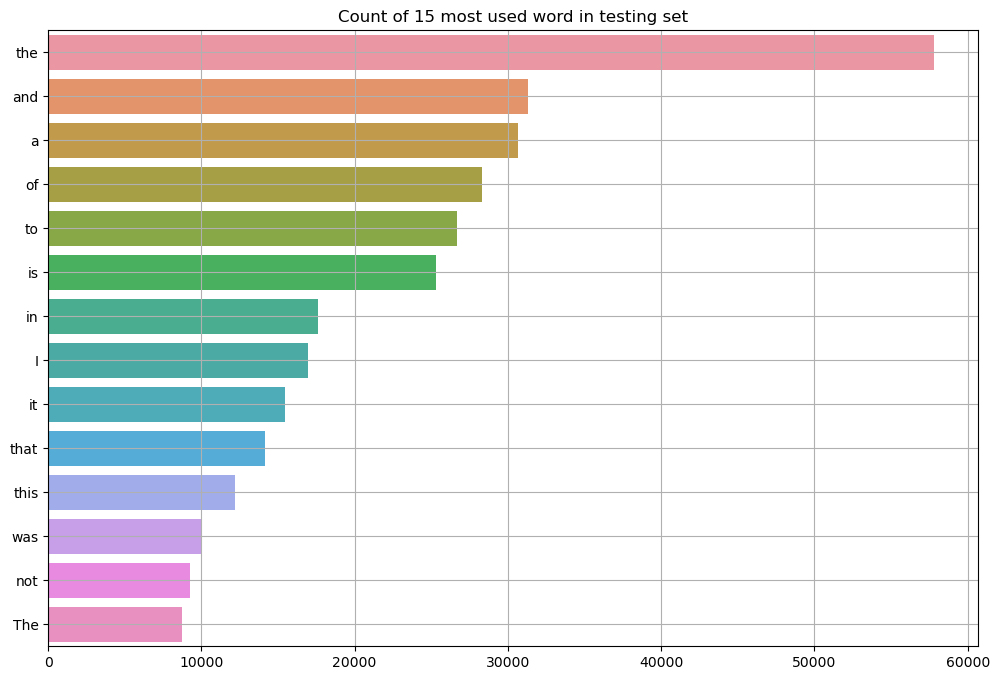

In [25]:
plt.figure(figsize=(12,8))
sns.barplot(x=test_count,y=test_word).set_title('Count of 15 most used word in testing set')
plt.grid()

# We will delete the embeddings as it takes too much memory

In [26]:
del glove_embeddings,train_oov,test_oov
gc.collect()

16701

# Model Building

In [27]:
num_words=50000
embeddings=256

In [28]:
tokenizer=Tokenizer(num_words=num_words,oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index=tokenizer.word_index
total_vocab=len(word_index)

In [29]:
print("Vocabulary of the dataset is : ",total_vocab)

Vocabulary of the dataset is :  100954


In [30]:
sequences_train=tokenizer.texts_to_sequences(X_train)
sequences_test=tokenizer.texts_to_sequences(X_test)

max_len=max(max([len(x) for x in sequences_train]),max([len(x) for x in sequences_test]))

train_padded=pad_sequences(sequences_train,maxlen=max_len)
test_padded=pad_sequences(sequences_test,maxlen=max_len)

In [31]:
X_train,X_val,Y_train,Y_val=train_test_split(train_padded,Y_train,
                                             test_size=0.05,random_state=10)

# We will 2 LSTM layers and Conv1D layer for training the model.
Using Dropout reduces the overfitting by decreasing the bias and is a must since there is lot of variance seen.

In [32]:
model= keras.Sequential()
model.add(Embedding(num_words,embeddings,input_length=max_len))
model.add(Conv1D(256,10,activation='relu'))
model.add(keras.layers.Bidirectional(LSTM(128,return_sequences=True)))
model.add(LSTM(64))
model.add(keras.layers.Dropout(0.4))
model.add(Dense(2,activation='softmax'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2527, 256)         12800000  
                                                                 
 conv1d (Conv1D)             (None, 2518, 256)         655616    
                                                                 
 bidirectional (Bidirectiona  (None, 2518, 256)        394240    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 64)                82176     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                        

In [34]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

# Callbacks are really helpful as they stop our model when the validation accuracy of our model starts decreasing for 
# consecutive 2 epochs as well save the best possible weights which gives highest validation accuracy

In [35]:
es= EarlyStopping(monitor='val_accuracy',
                  patience=2
                 )

checkpoints=ModelCheckpoint(filepath='./',
                            monitor="val_accuracy",
                            verbose=0,
                            save_best_only=True
                           )

callbacks=[es,checkpoints]

In [36]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

history=model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=5,callbacks=callbacks)

Epoch 1/5
1336/1336 [==============================] - ETA: 0s - loss: 0.3704 - accuracy: 0.8360 INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


1336/1336 [==============================] - 46004s 34s/step - loss: 0.3704 - accuracy: 0.8360 - val_loss: 0.2772 - val_accuracy: 0.8884
Epoch 2/5
1336/1336 [==============================] - ETA: 0s - loss: 0.1898 - accuracy: 0.9298 INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


1336/1336 [==============================] - 57998s 43s/step - loss: 0.1898 - accuracy: 0.9298 - val_loss: 0.2511 - val_accuracy: 0.9067
Epoch 3/5
1336/1336 [==============================] - 73248s 55s/step - loss: 0.1011 - accuracy: 0.9665 - val_loss: 0.2980 - val_accuracy: 0.8920
Epoch 4/5
1336/1336 [==============================] - 70654s 53s/step - loss: 0.0481 - accuracy: 0.9851 - val_loss: 0.3747 - val_accuracy: 0.8862


# Model Evaluation

In [37]:
def plot_graph(history,string):
    
    plt.plot(history.history[string],label='training '+string)
    plt.plot(history.history['val_'+string],label='validation '+string)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.title(string+' vs epochs')
    plt.show()

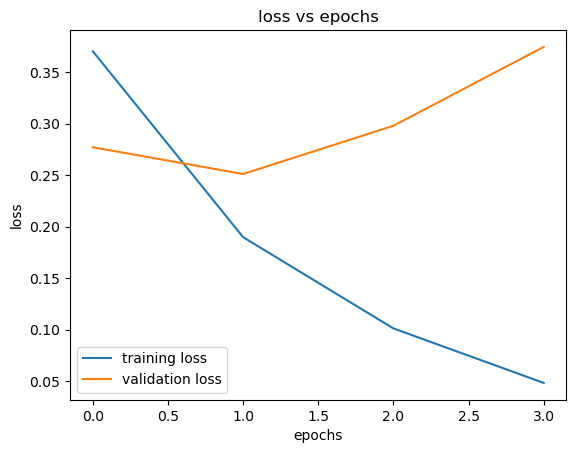

In [38]:
plot_graph(history,'loss')

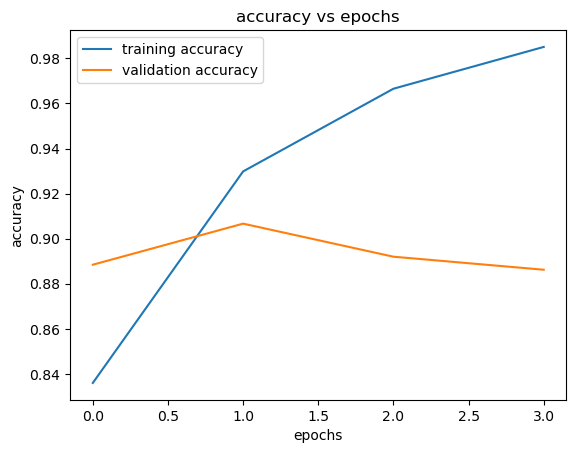

In [39]:
plot_graph(history,'accuracy')

In [40]:
model.save('imdb_model.h5')

In [41]:
print("Model Performance on test set")
result = model.evaluate(test_padded,Y_test)
print(dict(zip(model.metrics_names, result)))

Model Performance on test set
157/157 [==============================] - 955s 6s/step - loss: 0.3637 - accuracy: 0.8926
{'loss': 0.3637019991874695, 'accuracy': 0.8925999999046326}
